In [1]:
# 03_clustering_playlists.ipynb
# Playlist-level clustering on MPD playlists using audio features

from pathlib import Path
import sys
import json
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

# Optional: wordclouds for playlist titles
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
    print("wordcloud available.")
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("wordcloud NOT installed. Run `pip install wordcloud` to enable wordcloud plots.")

# Make src importable if we need it later
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"


wordcloud available.
PROJECT_ROOT: C:\Users\Kiera\Music_Recommender


In [2]:
# Track audio features
features_path = DATA_PROCESSED / "combined_features.csv"
tracks_df = pd.read_csv(features_path)
tracks_df["track_id"] = tracks_df["track_id"].astype(str)

print("tracks_df shape:", tracks_df.shape)
tracks_df.head()


tracks_df shape: (4589288, 17)


track_id  danceability  energy  key  loudness  mode  \
0  0000QuApNltQzqS5ROXcQ7         0.629   0.199    4   -15.258     1   
1  0000j9zugybaOxAeENtFRU         0.680   0.378    5    -7.379     1   
2  0000korRHja9p9XaR5UA5m         0.708   0.714    6    -7.579     1   
3  0000uJA4xCdxThagdLkkLR         0.458   0.591    5    -5.621     1   
4  00018DRtkxXS7SmAG4ciN6         0.456   0.324    8   -11.521     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0610        0.9250          0.000000    0.1100    0.587   66.469   
1       0.0685        0.8850          0.000013    0.1200    0.963  116.877   
2       0.0362        0.3970          0.000047    0.3540    0.756  120.538   
3       0.0326        0.5680          0.000015    0.2860    0.654  184.913   
4       0.0342        0.0242          0.596000    0.0868    0.522  184.970   

   duration_ms    year explicit  time_signature  popularity  
0     141813.0  2012.0      NaN             4.0         NaN  
1     112107.0     NaN      NaN             4.0         NaN  
2     235666.0  1995.0      NaN             4.0         NaN  
3     161187.0     NaN      NaN             3.0         NaN  
4     238827.0     NaN      NaN             3.0         NaN

In [3]:
# MPD interactions (flattened playlists)
interactions_path = DATA_PROCESSED / "interactions.parquet"
interactions = pd.read_parquet(interactions_path)
interactions["track_id"] = interactions["track_id"].astype(str)

print("interactions shape:", interactions.shape)
interactions.head()


interactions shape: (6685101, 4)


pid                track_id  pos  duration_ms
0    0  0UaMYEvWZi0ZqiDOoHU3YI    0       226863
1    0  6I9VzXrHxO9rA9A5euc8Ak    1       198800
2    0  0WqIKmW4BTrj3eJFmnCKMv    2       235933
3    0  1AWQoqb9bSvzTjaLralEkT    3       267266
4    0  1lzr43nnXAijIGYnCT8M8H    4       227600

In [4]:
feature_ids = set(tracks_df["track_id"])
interactions = interactions[interactions["track_id"].isin(feature_ids)].copy()
print("Interactions after filtering to feature-space tracks:", interactions.shape)


Interactions after filtering to feature-space tracks: (6175813, 4)


In [5]:
playlist_meta_path = DATA_PROCESSED / "playlist_metadata.csv"

if playlist_meta_path.exists():
    playlist_meta = pd.read_csv(playlist_meta_path)
    print("Loaded playlist_metadata.csv from:", playlist_meta_path)
else:
    print("playlist_metadata.csv not found – rebuilding from MPD JSON files...")
    MPD_DIR = DATA_RAW / "mpd" / "data"
    mpd_files = sorted(MPD_DIR.glob("mpd.slice.*.json"))
    print("Found MPD slice files:", len(mpd_files))

    playlist_meta_rows = []
    for path in mpd_files:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for pl in data.get("playlists", []):
            playlist_meta_rows.append({
                "pid": pl["pid"],
                "name": pl.get("name", ""),
                "num_tracks": pl.get("num_tracks", None),
                "num_followers": pl.get("num_followers", None),
                "num_albums": pl.get("num_albums", None),
                "num_artists": pl.get("num_artists", None),
                "modified_at": pl.get("modified_at", None),
            })
    playlist_meta = pd.DataFrame(playlist_meta_rows)
    playlist_meta.to_csv(playlist_meta_path, index=False)
    print("Rebuilt and saved playlist_metadata.csv:", playlist_meta_path)

print("playlist_meta shape:", playlist_meta.shape)
playlist_meta.head()


Loaded playlist_metadata.csv from: C:\Users\Kiera\Music_Recommender\data\processed\playlist_metadata.csv
playlist_meta shape: (100000, 7)


pid              name  num_tracks  num_followers  num_albums  num_artists  \
0    0        Throwbacks          52              1          47           37   
1    1  Awesome Playlist          39              1          23           21   
2    2           korean           64              1          51           31   
3    3               mat         126              1         107           86   
4    4               90s          17              2          16           16   

   modified_at  
0   1493424000  
1   1506556800  
2   1505692800  
3   1501027200  
4   1401667200

In [6]:
# Choose track feature columns for clustering
feature_cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]

# Ensure all exist
missing = [c for c in feature_cols if c not in tracks_df.columns]
print("Missing feature columns (should be empty):", missing)

track_feat_small = tracks_df[["track_id"] + feature_cols].copy()

# Merge interactions with track features
inter_feat = interactions.merge(
    track_feat_small,
    on="track_id",
    how="inner",
)

print("inter_feat shape after joining track features:", inter_feat.shape)
inter_feat.head()


Missing feature columns (should be empty): []
inter_feat shape after joining track features: (6175813, 16)


pid                track_id  pos  duration_ms  danceability  energy  key  \
0    0  0UaMYEvWZi0ZqiDOoHU3YI    0       226863         0.904   0.813    4   
1    0  6I9VzXrHxO9rA9A5euc8Ak    1       198800         0.774   0.838    5   
2    0  0WqIKmW4BTrj3eJFmnCKMv    2       235933         0.664   0.758    2   
3    0  1AWQoqb9bSvzTjaLralEkT    3       267266         0.892   0.714    4   
4    0  1lzr43nnXAijIGYnCT8M8H    4       227600         0.853   0.606    0   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -7.105     0       0.1210       0.03110          0.006970    0.0471   
1    -3.914     0       0.1140       0.02490          0.025000    0.2420   
2    -6.583     0       0.2100       0.00238          0.000000    0.0598   
3    -6.055     0       0.1410       0.20100          0.000234    0.0521   
4    -4.596     1       0.0713       0.05610          0.000000    0.3130   

   valence    tempo  time_signature  
0    0.810  125.461             4.0  
1    0.924  143.040             4.0  
2    0.701   99.259             4.0  
3    0.817  100.972             4.0  
4    0.654   94.759             4.0

In [7]:
# Playlist-level feature vectors (mean over tracks)
playlist_features = (
    inter_feat
    .groupby("pid")[feature_cols]
    .mean()
    .reset_index()
)

print("playlist_features shape:", playlist_features.shape)
playlist_features.head()


playlist_features shape: (100000, 13)


pid  danceability    energy       key  loudness      mode  speechiness  \
0    0      0.664077  0.781077  5.038462 -4.891212  0.692308     0.103698   
1    1      0.492408  0.695923  4.461538 -8.107974  0.538462     0.091000   
2    2      0.671063  0.692953  5.000000 -4.875594  0.515625     0.096425   
3    3      0.514429  0.620902  5.103175 -9.618865  0.714286     0.067001   
4    4      0.576294  0.650418  3.352941 -7.634529  0.823529     0.041212   

   acousticness  instrumentalness  liveness   valence       tempo  \
0      0.083674          0.000674  0.187087  0.642750  121.157500   
1      0.162225          0.223708  0.179364  0.476692  124.986846   
2      0.269100          0.000638  0.168894  0.565078  114.595984   
3      0.273514          0.203156  0.188333  0.451226  125.547611   
4      0.177189          0.081759  0.166524  0.490294  127.725059   

   time_signature  
0        4.000000  
1        3.769231  
2        4.000000  
3        3.952381  
4        3.941176

In [8]:
playlist_sizes = (
    interactions.groupby("pid")["track_id"]
    .count()
    .rename("n_tracks")
    .reset_index()
)

playlist_df = (
    playlist_features
    .merge(playlist_meta, on="pid", how="left")
    .merge(playlist_sizes, on="pid", how="left")
)

print("playlist_df shape after joining metadata & sizes:", playlist_df.shape)
playlist_df[["pid", "name", "n_tracks"] + feature_cols].head()


playlist_df shape after joining metadata & sizes: (100000, 20)


pid              name  n_tracks  danceability    energy       key  \
0    0        Throwbacks        52      0.664077  0.781077  5.038462   
1    1  Awesome Playlist        39      0.492408  0.695923  4.461538   
2    2           korean         64      0.671063  0.692953  5.000000   
3    3               mat       126      0.514429  0.620902  5.103175   
4    4               90s        17      0.576294  0.650418  3.352941   

   loudness      mode  speechiness  acousticness  instrumentalness  liveness  \
0 -4.891212  0.692308     0.103698      0.083674          0.000674  0.187087   
1 -8.107974  0.538462     0.091000      0.162225          0.223708  0.179364   
2 -4.875594  0.515625     0.096425      0.269100          0.000638  0.168894   
3 -9.618865  0.714286     0.067001      0.273514          0.203156  0.188333   
4 -7.634529  0.823529     0.041212      0.177189          0.081759  0.166524   

    valence       tempo  time_signature  
0  0.642750  121.157500        4.000000  
1  0.476692  124.986846        3.769231  
2  0.565078  114.595984        4.000000  
3  0.451226  125.547611        3.952381  
4  0.490294  127.725059        3.941176

In [9]:
print("Playlist size summary:")
display(playlist_df["n_tracks"].describe())

MIN_TRACKS = 5
playlist_df = playlist_df[playlist_df["n_tracks"] >= MIN_TRACKS].reset_index(drop=True)

print("After filtering small playlists (<5 tracks):", playlist_df.shape)


Playlist size summary:


count    100000.000000
mean         61.758130
std          49.985938
min           1.000000
25%          24.000000
50%          46.000000
75%          85.000000
max         247.000000
Name: n_tracks, dtype: float64

After filtering small playlists (<5 tracks): (99723, 20)


In [10]:
# Feature matrix for all playlists
X_pl = playlist_df[feature_cols].values.astype(float)

scaler = StandardScaler()
X_pl_scaled = scaler.fit_transform(X_pl)

print("X_pl_scaled shape:", X_pl_scaled.shape)


X_pl_scaled shape: (99723, 12)


In [11]:
# Subsample for t-SNE visualisation
N_TSNE = 10000  # adjust if it's slow; 5,000–10,000 is fine
n_total = X_pl_scaled.shape[0]
tsne_indices = np.random.choice(n_total, size=min(N_TSNE, n_total), replace=False)

X_tsne_input = X_pl_scaled[tsne_indices]
print("t-SNE input shape:", X_tsne_input.shape)


t-SNE input shape: (10000, 12)


In [12]:
print("Running t-SNE... this may take a few minutes for 10k points.")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,       # scikit-learn >=1.2 uses max_iter, not n_iter
    metric="euclidean",
    random_state=42,
    init="random",
)

X_tsne = tsne.fit_transform(X_tsne_input)
print("X_tsne shape:", X_tsne.shape)


Running t-SNE... this may take a few minutes for 10k points.
X_tsne shape: (10000, 2)


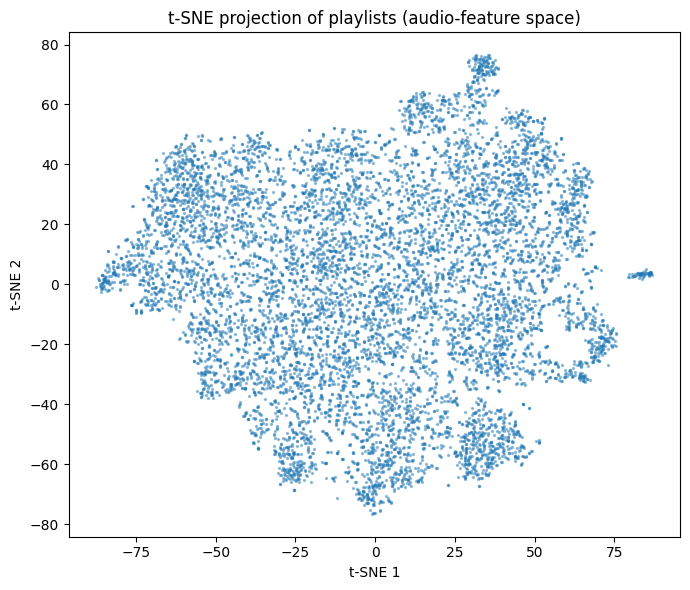

In [13]:
plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=2, alpha=0.4)
plt.title("t-SNE projection of playlists (audio-feature space)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [14]:
from tqdm.auto import tqdm

# Subsample for clustering evaluation
N_CLUSTER_EVAL = 20000
n_total = X_pl_scaled.shape[0]
cluster_eval_idx = np.random.choice(n_total, size=min(N_CLUSTER_EVAL, n_total), replace=False)
X_eval = X_pl_scaled[cluster_eval_idx]

print("X_eval shape (for model selection):", X_eval.shape)


X_eval shape (for model selection): (20000, 12)


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def maybe_sample_for_silhouette(X, labels, max_samples=2000, random_state=42):
    """
    Compute silhouette on at most max_samples points to avoid n^2 memory blow-ups.
    """
    n = X.shape[0]
    if n > max_samples:
        idx = np.random.choice(n, size=max_samples, replace=False)
        return silhouette_score(X[idx], labels[idx])
    else:
        return silhouette_score(X, labels)


In [16]:
K_VALUES = list(range(2, 41))  # 2..40
results_rows = []

# ----- KMeans -----
print("Running KMeans model selection...")
for K in tqdm(K_VALUES, desc="KMeans K loop"):
    kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_eval)

    sil = maybe_sample_for_silhouette(X_eval, labels, max_samples=2000)
    db = davies_bouldin_score(X_eval, labels)
    ch = calinski_harabasz_score(X_eval, labels)

    results_rows.append({
        "model": "KMeans",
        "K": K,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "n_points": X_eval.shape[0],
    })

# ----- GMM -----
print("Running GMM model selection...")
for K in tqdm(K_VALUES, desc="GMM K loop"):
    gmm = GaussianMixture(
        n_components=K,
        covariance_type="full",
        random_state=42,
    )
    labels = gmm.fit_predict(X_eval)

    sil = maybe_sample_for_silhouette(X_eval, labels, max_samples=2000)
    db = davies_bouldin_score(X_eval, labels)
    ch = calinski_harabasz_score(X_eval, labels)

    results_rows.append({
        "model": "GaussianMixture",
        "K": K,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "n_points": X_eval.shape[0],
    })

scores_df = pd.DataFrame(results_rows)
scores_df.head()


Running KMeans model selection...


KMeans K loop: 100%|██████████| 39/39 [00:05<00:00,  7.31it/s]


Running GMM model selection...


GMM K loop: 100%|██████████| 39/39 [03:37<00:00,  5.57s/it]


model  K  silhouette  davies_bouldin  calinski_harabasz  n_points
0  KMeans  2    0.316464        1.480326        5903.071647     20000
1  KMeans  3    0.164604        1.829774        4659.938523     20000
2  KMeans  4    0.167116        1.645660        4287.552761     20000
3  KMeans  5    0.141964        1.736996        3774.918923     20000
4  KMeans  6    0.146975        1.693806        3469.032274     20000

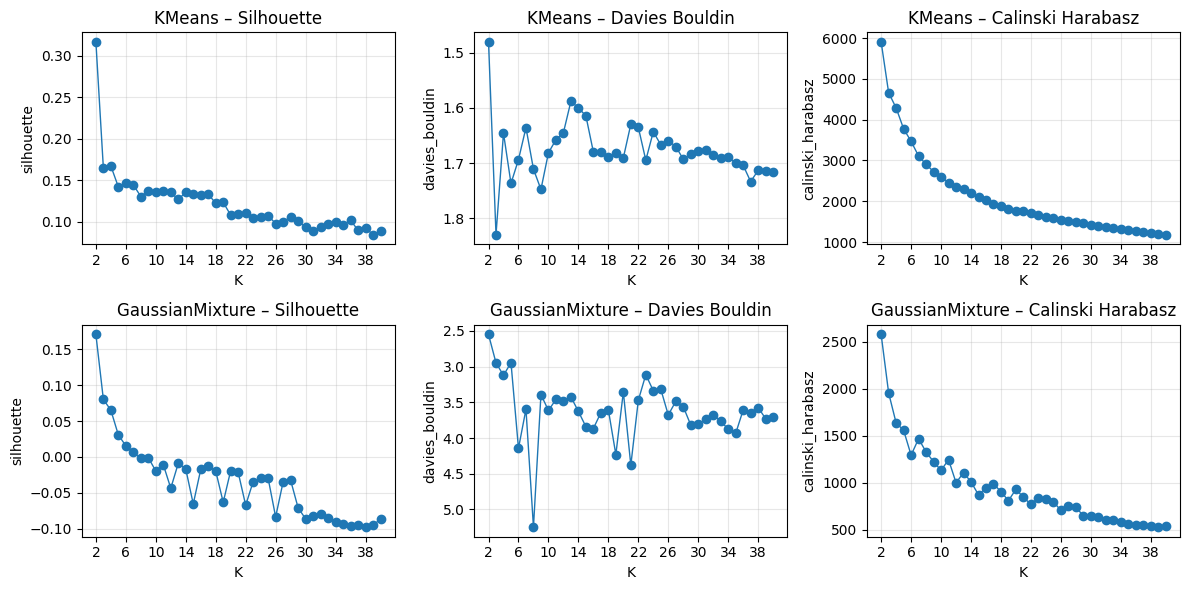

In [17]:
models = ["KMeans", "GaussianMixture"]
metrics = ["silhouette", "davies_bouldin", "calinski_harabasz"]

fig, axes = plt.subplots(len(models), len(metrics), figsize=(12, 3 * len(models)))

for i, model in enumerate(models):
    df_m = scores_df[scores_df["model"] == model].sort_values("K")
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if len(models) > 1 else axes[j]
        ax.plot(df_m["K"], df_m[metric], marker="o", linewidth=1)
        ax.set_title(f"{model} – {metric.replace('_', ' ').title()}")
        ax.set_xlabel("K")
        ax.set_xticks(df_m["K"][::4])
        ax.grid(True, alpha=0.3)
        if metric == "davies_bouldin":
            ax.invert_yaxis()  # lower is better; optional
        ax.set_ylabel(metric)

plt.tight_layout()
plt.show()


In [18]:
best_K = {}

for model in models:
    df_m = scores_df[scores_df["model"] == model]
    row_best = df_m.loc[df_m["davies_bouldin"].idxmin()]
    best_K[model] = int(row_best["K"])
    print(
        f"{model}: best K by Davies–Bouldin = {best_K[model]} "
        f"(DB = {row_best['davies_bouldin']:.3f}, "
        f"Sil = {row_best['silhouette']:.3f}, "
        f"CH = {row_best['calinski_harabasz']:.1f})"
    )

best_K


KMeans: best K by Davies–Bouldin = 2 (DB = 1.480, Sil = 0.316, CH = 5903.1)
GaussianMixture: best K by Davies–Bouldin = 2 (DB = 2.549, Sil = 0.171, CH = 2577.5)


{'KMeans': 2, 'GaussianMixture': 2}

In [19]:
X_full = X_pl_scaled

# KMeans on full data
K_kmeans = 20 #best_K["KMeans"]
kmeans_full = KMeans(n_clusters=K_kmeans, random_state=42, n_init="auto")
labels_kmeans_full = kmeans_full.fit_predict(X_full)

playlist_df["cluster_KMeans"] = labels_kmeans_full

print("KMeans full-data clustering complete. K =", K_kmeans)
playlist_df[["pid", "name", "cluster_KMeans"]].head()


KMeans full-data clustering complete. K = 20


pid              name  cluster_KMeans
0    0        Throwbacks               7
1    1  Awesome Playlist              16
2    2           korean               12
3    3               mat              16
4    4               90s               1

In [20]:
K_gmm = 20 #best_K["GaussianMixture"]
gmm_full = GaussianMixture(
    n_components=K_gmm,
    covariance_type="full",
    random_state=42,
)
labels_gmm_full = gmm_full.fit_predict(X_full)

playlist_df["cluster_GMM"] = labels_gmm_full

print("GMM full-data clustering complete. K =", K_gmm)


GMM full-data clustering complete. K = 20


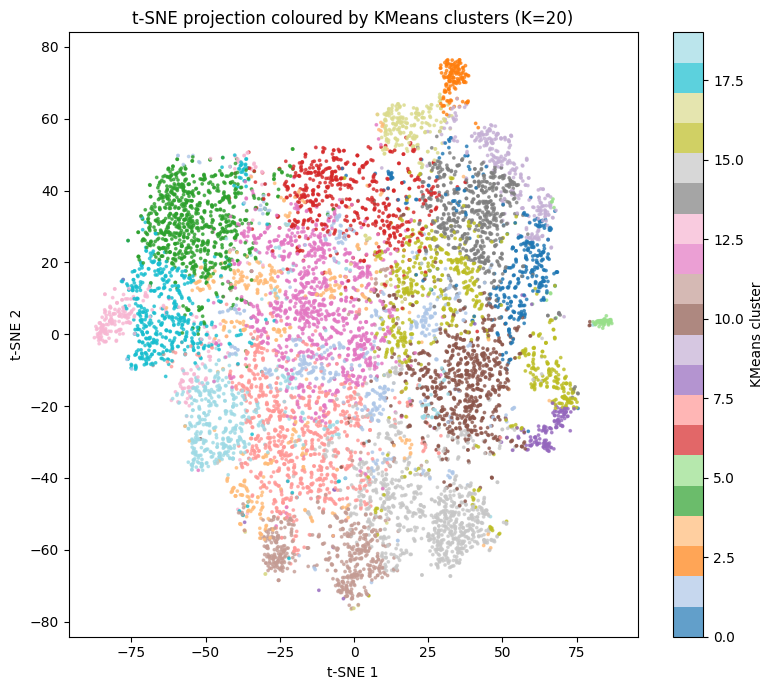

In [21]:
def labels_for_indices(labels_all, indices):
    labels_all = np.asarray(labels_all)
    return labels_all[indices]

labels_tsne_kmeans = labels_for_indices(playlist_df["cluster_KMeans"].values, tsne_indices)

plt.figure(figsize=(8, 7))
sc = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels_tsne_kmeans,
    s=3,
    alpha=0.7,
    cmap="tab20",
)
plt.colorbar(sc, label="KMeans cluster")
plt.title(f"t-SNE projection coloured by KMeans clusters (K={K_kmeans})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


C:\Users\Kiera\AppData\Local\Temp\ipykernel_49044\859109298.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


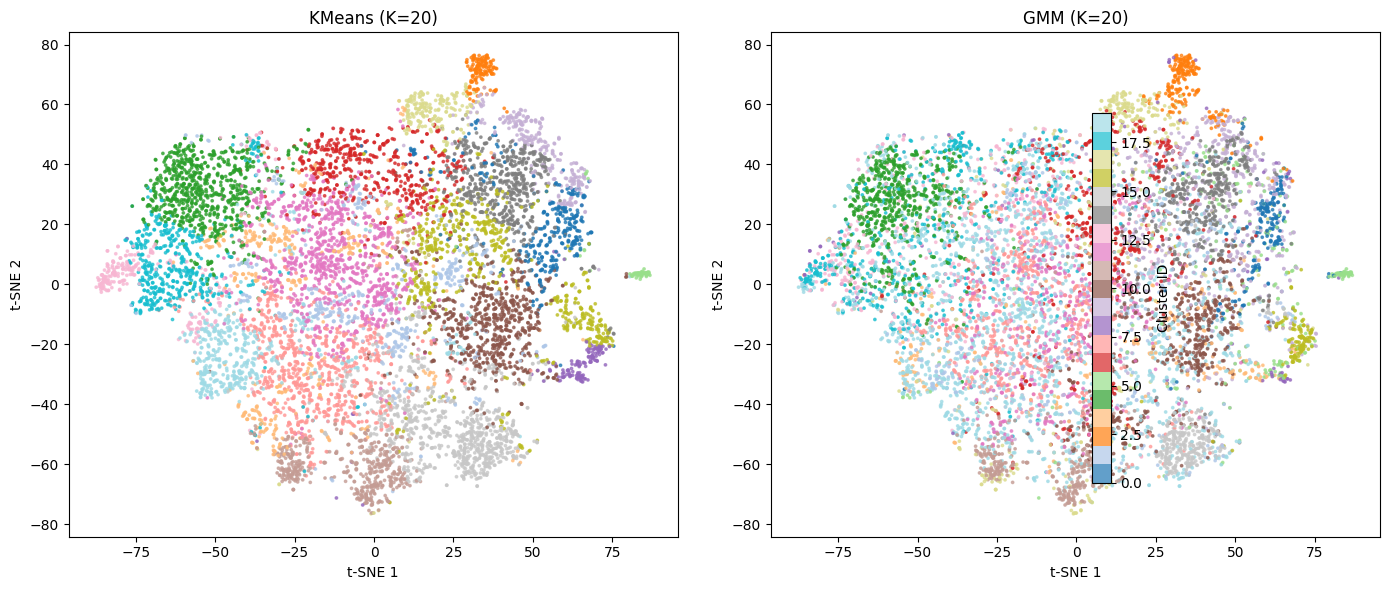

In [22]:
labels_tsne_gmm = labels_for_indices(playlist_df["cluster_GMM"].values, tsne_indices)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels_tsne_kmeans,
    s=3,
    alpha=0.7,
    cmap="tab20",
)
axes[0].set_title(f"KMeans (K={K_kmeans})")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

im = axes[1].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels_tsne_gmm,
    s=3,
    alpha=0.7,
    cmap="tab20",
)
axes[1].set_title(f"GMM (K={K_gmm})")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label="Cluster ID")
plt.tight_layout()
plt.show()


In [23]:
cluster_col = "cluster_KMeans"
K_clusters = K_kmeans

titles_df = playlist_df[["pid", "name", cluster_col]].copy()
titles_df.rename(columns={"name": "title"}, inplace=True)

top_n = 10
cluster_to_titles = {}

for c in range(K_clusters):
    sub = titles_df[titles_df[cluster_col] == c]
    counts = (
        sub["title"]
        .fillna("")
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .value_counts()
        .head(top_n)
    )
    cluster_to_titles[c] = list(counts.index)

max_len = max(len(v) for v in cluster_to_titles.values())
rows = []
for i in range(max_len):
    row = {}
    for c in range(K_clusters):
        titles = cluster_to_titles[c]
        row[f"Cluster {c}"] = titles[i] if i < len(titles) else np.nan
    rows.append(row)

titles_matrix_df = pd.DataFrame(rows)
titles_matrix_df


Cluster 0  Cluster 1     Cluster 2 Cluster 3 Cluster 4  Cluster 5  \
0  Christmas      Chill     Classical     Chill       Rap      Banda   
1     Disney      chill         Study   Workout       rap   Corridos   
2     Oldies     Summer  Instrumental   workout       lit      banda   
3  christmas       jams     classical     Dance     party   corridos   
4     oldies     summer         Piano       EDM       Lit    Mexican   
5   Musicals     oldies   Soundtracks     Party      hype    Spanish   
6     disney        Pop         study    summer     Party  Rancheras   
7  CHRISTMAS       2017         Sleep     chill       🔥🔥🔥      Blues   
8   musicals       Rock   Study Music    Summer     Chill         🇲🇽   
9      Blues  Throwback       Classic      jams     litty    mexican   

   Cluster 6   Cluster 7      Cluster 8  Cluster 9    Cluster 10 Cluster 11  \
0      chill     Workout        Worship  Christmas        Oldies       Rock   
1      Chill   throwback         Gospel     Disney        oldies        EDM   
2      feels     workout        worship       Jazz      Classics    Workout   
3        R&B   Throwback         Praise  christmas  Classic Rock    Dubstep   
4      vibes       Party      Christian      sleep       Country       rock   
5      Vibes  throwbacks          Jesus      Sleep          80's      Metal   
6      Feels     Running      christian      chill           80s    workout   
7        sex  Throwbacks         Church   Musicals      classics        Gym   
8       2017         Pop  Worship Music       jazz          Rock        edm   
9  Slow Jams       party         gospel     disney       country      House   

    Cluster 12      Cluster 13 Cluster 14    Cluster 15 Cluster 16  \
0        Chill             Rap      Chill       Country    Worship   
1        chill         Hip Hop      chill       country      Chill   
2       summer          Eminem      feels          Rock    Country   
3         2017             rap      sleep           90s  Christian   
4         2016      Old School        sad  Classic Rock    worship   
5          new          Reggae   Acoustic   Alternative      chill   
6          Pop  Old School Rap      Feels          rock    country   
7         jams      old school      Sleep          90's  christian   
8       Summer         Hip hop       Calm       COUNTRY         <3   
9  Summer 2017         Hip-Hop      Relax        Summer      Feels   

      Cluster 17 Cluster 18  Cluster 19  
0          Chill        Rap      Reggae  
1           Jazz    Workout     Spanish  
2          chill    workout   Reggaeton  
3   Instrumental        rap     Bachata  
4  Instrumentals      Party       Salsa  
5          Beats        Gym   Throwback  
6          Study      party   throwback  
7         Trance       Hype  throwbacks  
8          House    Hip Hop  Throwbacks  
9     Electronic       hype     spanish

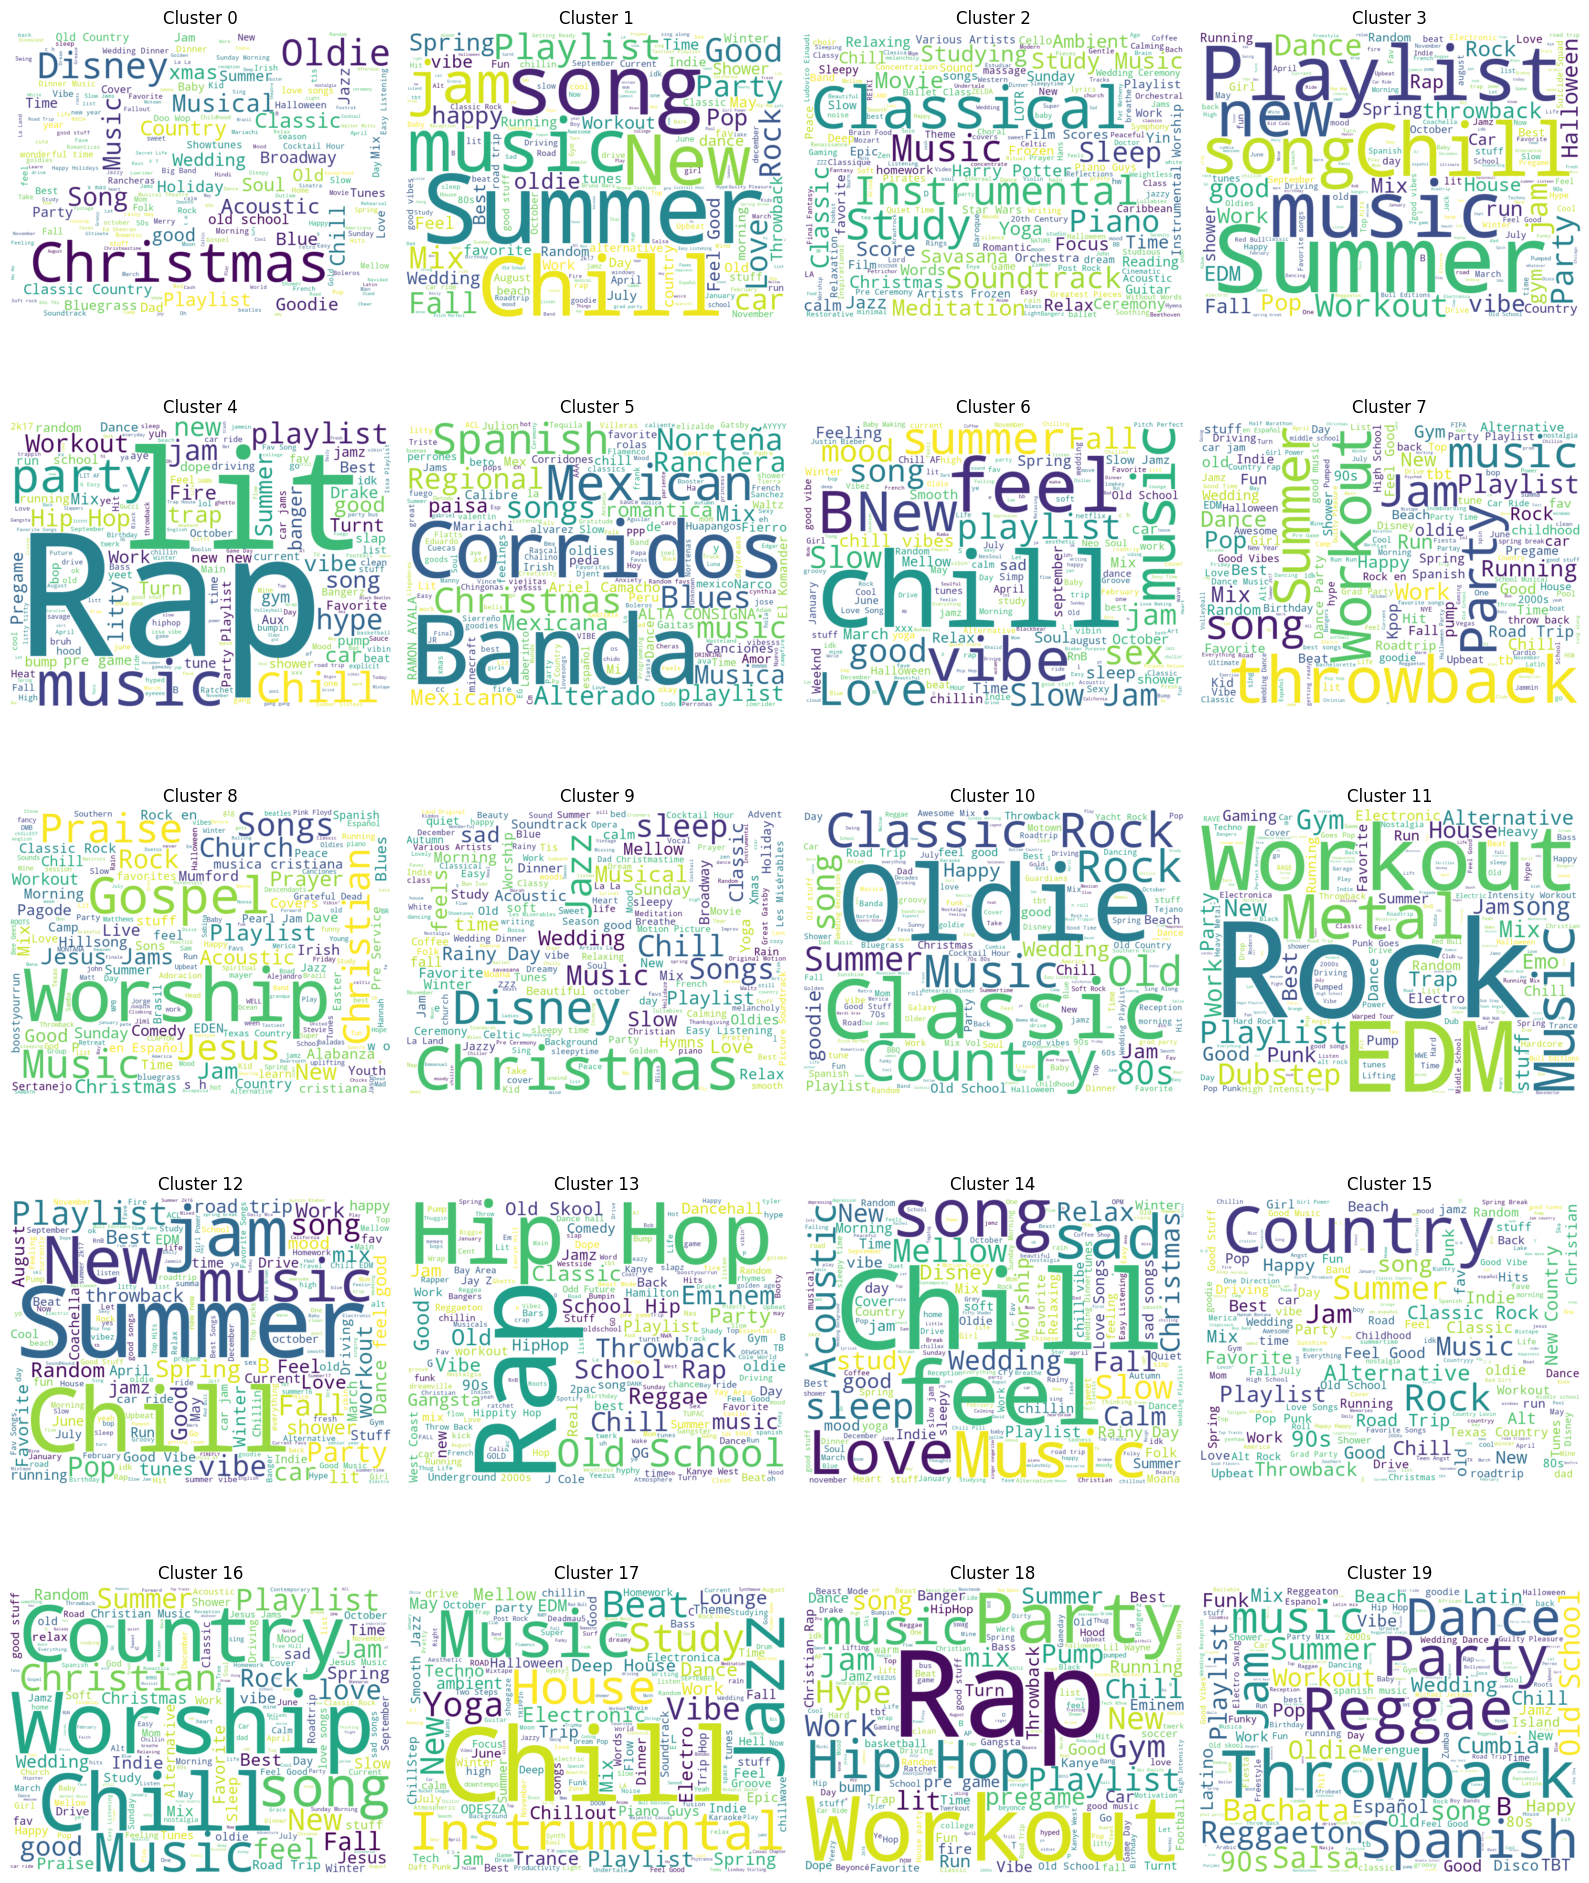

In [24]:
if not WORDCLOUD_AVAILABLE:
    print("wordcloud NOT installed – skipping wordcloud section.")
else:
    # Concatenate titles into text per cluster
    cluster_texts = {}
    for c in range(K_clusters):
        sub = titles_df[titles_df[cluster_col] == c]
        titles = (
            sub["title"]
            .dropna()
            .astype(str)
            .tolist()
        )
        text = " ".join(titles)
        cluster_texts[c] = text

    n_cols = 4
    n_rows = int(np.ceil(K_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for c in range(K_clusters):
        ax = axes[c]
        text = cluster_texts.get(c, "")
        if not text.strip():
            ax.axis("off")
            continue

        wc = WordCloud(width=800, height=600, background_color="white").generate(text)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Cluster {c}")

    for j in range(K_clusters, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


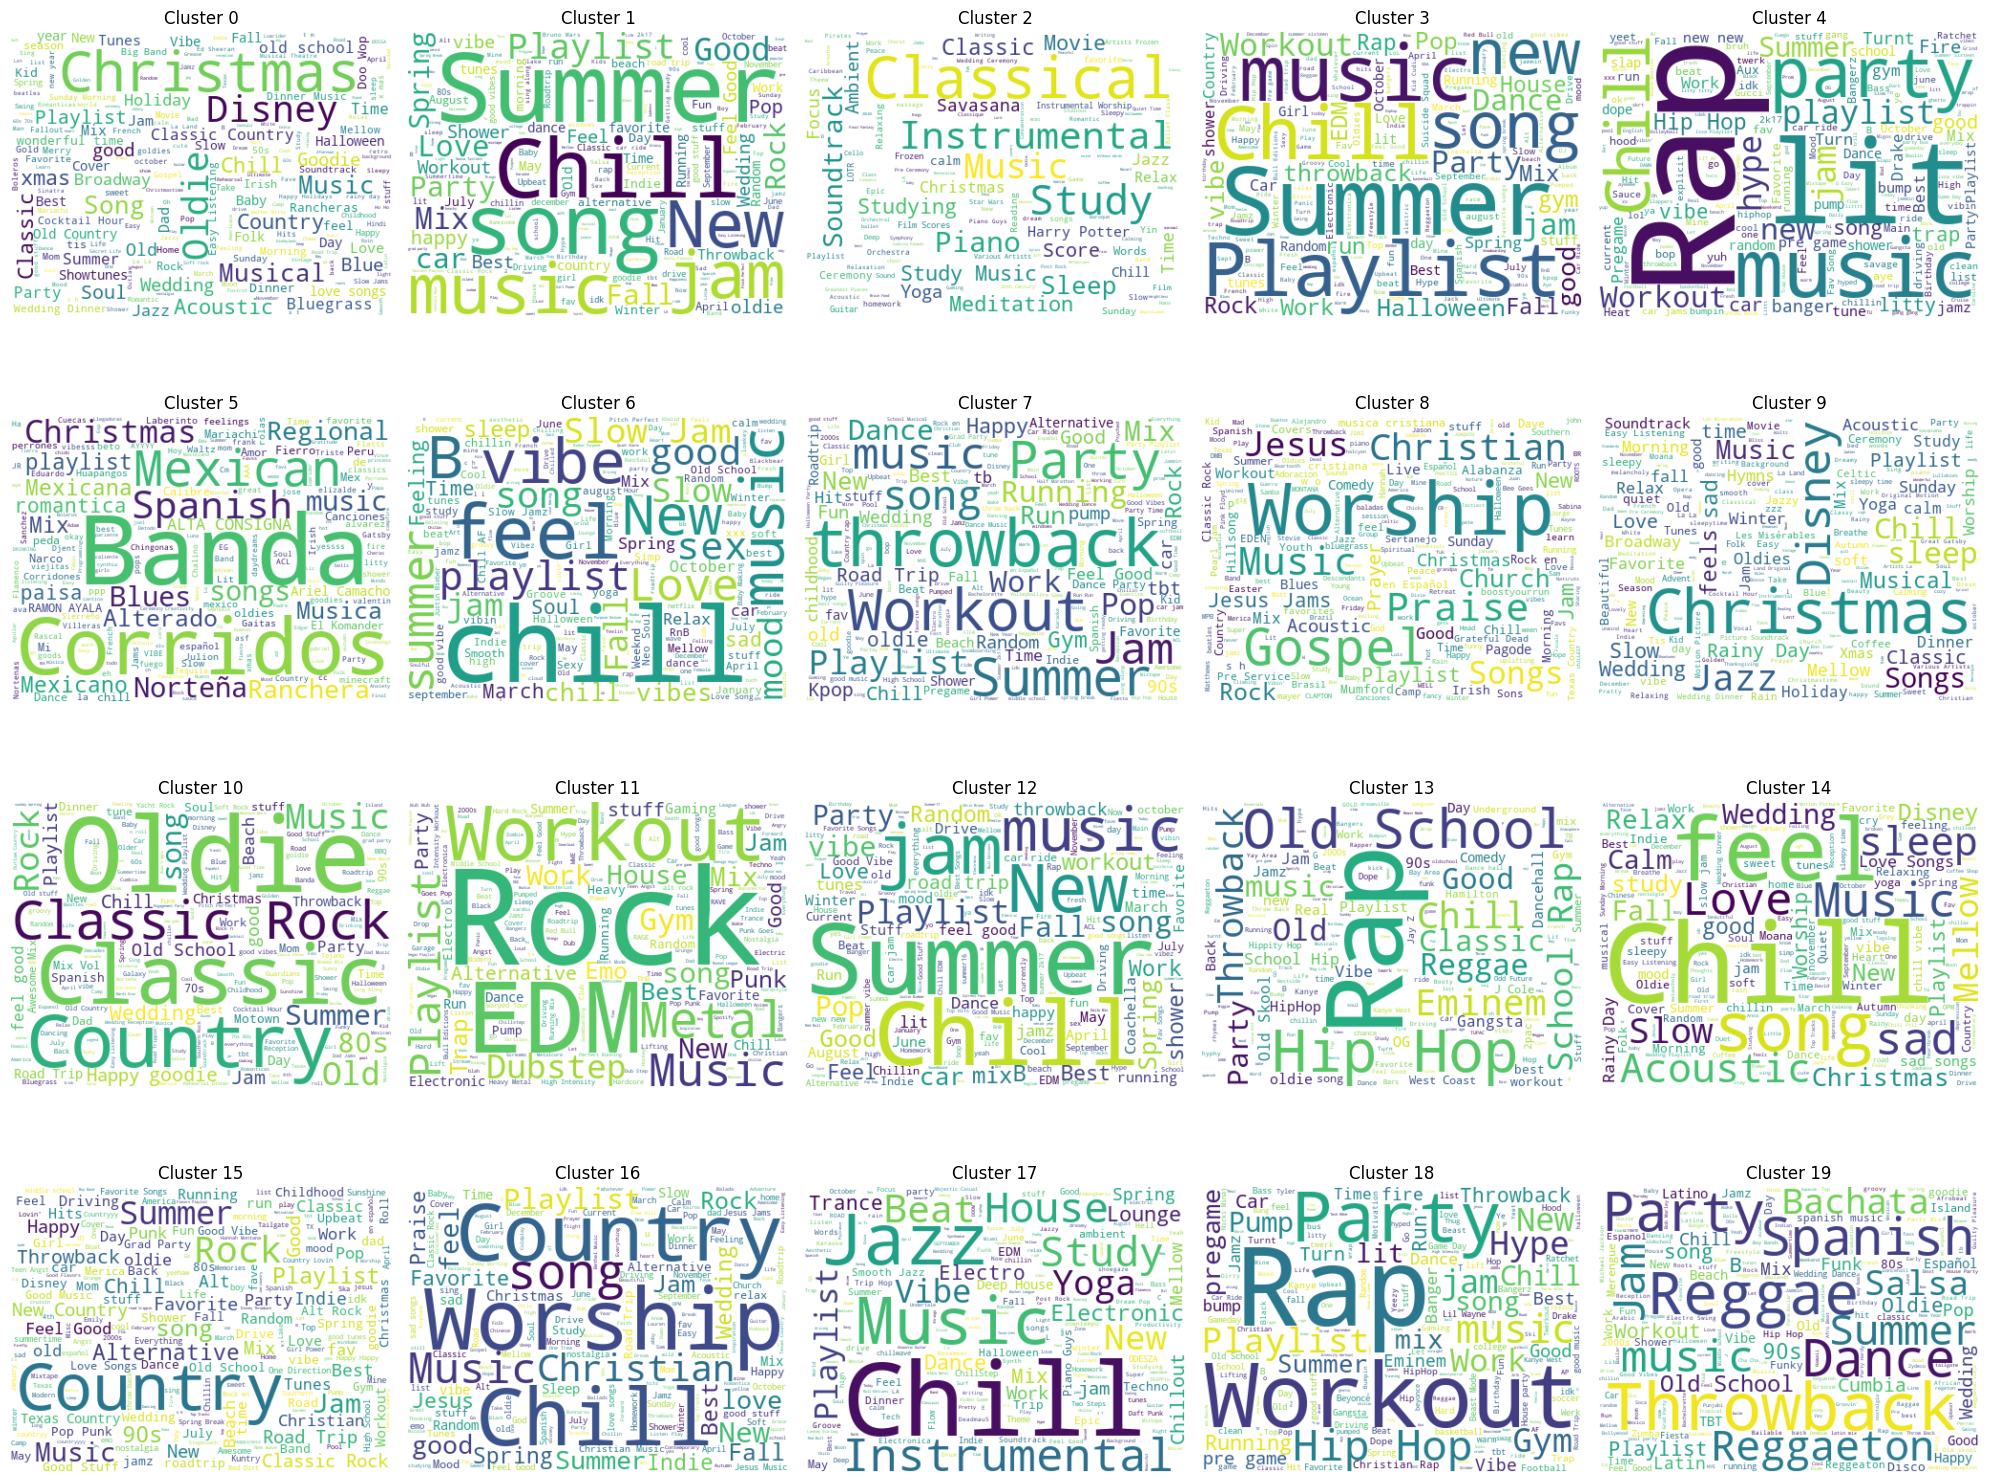

In [26]:
if not WORDCLOUD_AVAILABLE:
    print("wordcloud NOT installed – skipping wordcloud section.")
else:
    # Concatenate titles into text per cluster
    cluster_texts = {}
    for c in range(K_clusters):
        sub = titles_df[titles_df[cluster_col] == c]
        titles = (
            sub["title"]
            .dropna()
            .astype(str)
            .tolist()
        )
        text = " ".join(titles)
        cluster_texts[c] = text

    n_cols = 5
    n_rows = int(np.ceil(K_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for c in range(K_clusters):
        ax = axes[c]
        text = cluster_texts.get(c, "")
        if not text.strip():
            ax.axis("off")
            continue

        wc = WordCloud(width=400, height=300, background_color="white").generate(text)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Cluster {c}")

    for j in range(K_clusters, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


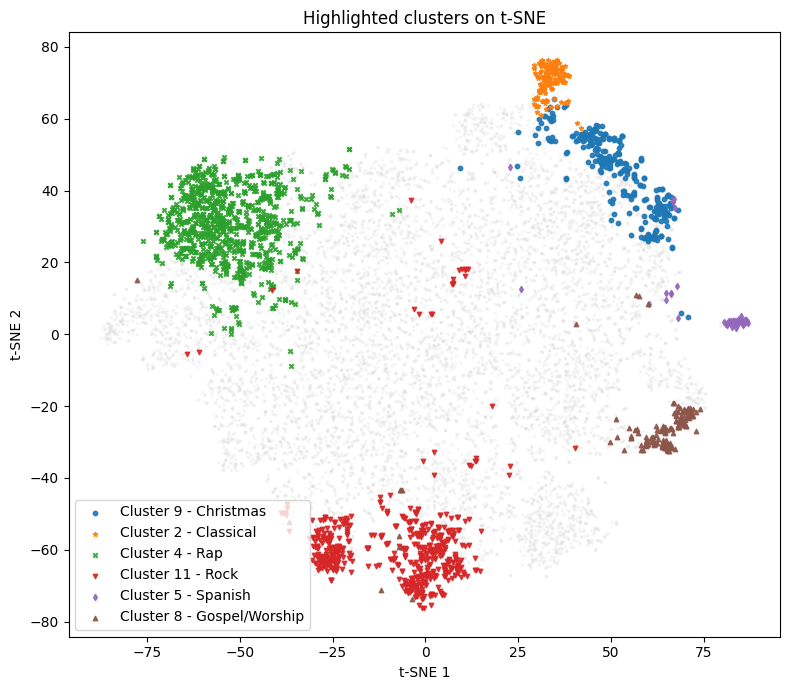

In [25]:
# Example: adjust these once you've identified interesting clusters
cluster_special_1 = 9   # e.g. christmas
cluster_special_2 = 4   # e.g. Rap
cluster_special_3 = 11  # e.g. Rock EDM
cluster_special_4 = 2  # e.g. Classical
cluster_special_5 = 5  # e.g. Spanish
cluster_special_6 = 8  # e.g. Gospel/Worship



labels_tsne_kmeans = labels_for_indices(playlist_df[cluster_col].values, tsne_indices)

plt.figure(figsize=(8, 7))
# All playlists in light grey
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    s=2,
    alpha=0.15,
    color="lightgrey",
)

# Cluster 1
mask1 = labels_tsne_kmeans == cluster_special_1
plt.scatter(
    X_tsne[mask1, 0],
    X_tsne[mask1, 1],
    s=10,
    alpha=0.9,
    label=f"Cluster 9 - Christmas",
)

# Cluster 4
mask4 = labels_tsne_kmeans == cluster_special_4
plt.scatter(
    X_tsne[mask4, 0],
    X_tsne[mask4, 1],
    s=10,
    alpha=0.9,
    marker="*",
    label=f"Cluster 2 - Classical",
)

# Cluster 2
mask2 = labels_tsne_kmeans == cluster_special_2
plt.scatter(
    X_tsne[mask2, 0],
    X_tsne[mask2, 1],
    s=10,
    alpha=0.9,
    marker="x",
    label=f"Cluster 4 - Rap",
)

# Cluster 3
mask3 = labels_tsne_kmeans == cluster_special_3
plt.scatter(
    X_tsne[mask3, 0],
    X_tsne[mask3, 1],
    s=10,
    alpha=0.9,
    marker="v",
    label=f"Cluster 11 - Rock",
)

# Cluster 5
mask5 = labels_tsne_kmeans == cluster_special_5
plt.scatter(
    X_tsne[mask5, 0],
    X_tsne[mask5, 1],
    s=10,
    alpha=0.9,
    marker="d",
    label=f"Cluster 5 - Spanish",
)

# Cluster 6
mask6 = labels_tsne_kmeans == cluster_special_6
plt.scatter(
    X_tsne[mask6, 0],
    X_tsne[mask6, 1],
    s=10,
    alpha=0.9,
    marker="^",
    label=f"Cluster 8 - Gospel/Worship",
)



plt.legend()
plt.title("Highlighted clusters on t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


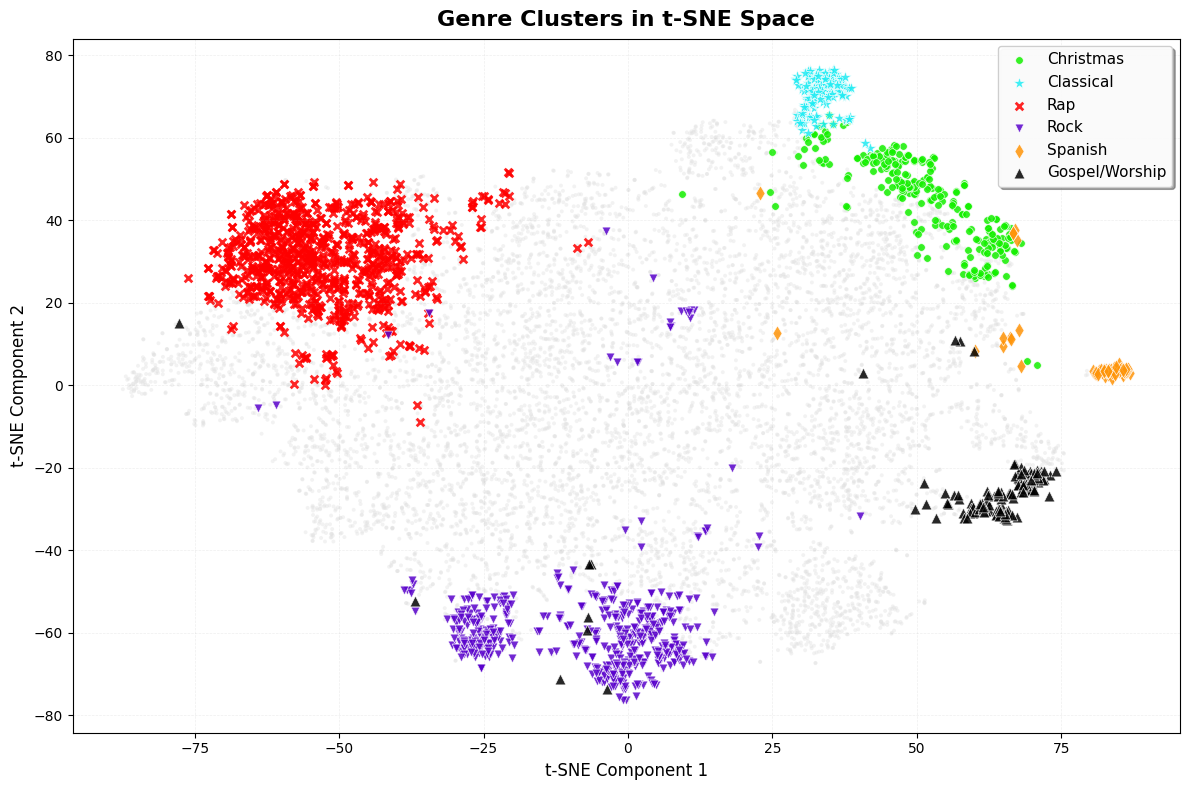

In [39]:
# Example: adjust these once you've identified interesting clusters
cluster_special_1 = 9   # e.g. christmas
cluster_special_2 = 4   # e.g. Rap
cluster_special_3 = 11  # e.g. Rock EDM
cluster_special_4 = 2  # e.g. Classical
cluster_special_5 = 5  # e.g. Spanish
cluster_special_6 = 8  # e.g. Gospel/Worship

labels_tsne_kmeans = labels_for_indices(playlist_df[cluster_col].values, tsne_indices)

plt.figure(figsize=(12, 8))

# All playlists in light grey as background
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    s=8,
    alpha=0.4,
    color="#e0e0e0",
    edgecolors='none',
    rasterized=True
)

# Define a vibrant color palette
colors = ["#14F000", "#21ECF3", "#FF0000", "#5A03CC", "#FF9408", "#020202"]

# Cluster 9 - Christmas
mask1 = labels_tsne_kmeans == cluster_special_1
plt.scatter(
    X_tsne[mask1, 0],
    X_tsne[mask1, 1],
    s=30,
    alpha=0.85,
    color=colors[0],
    edgecolors='white',
    linewidths=0.5,
    label="Christmas",
)

# Cluster 2 - Classical
mask4 = labels_tsne_kmeans == cluster_special_4
plt.scatter(
    X_tsne[mask4, 0],
    X_tsne[mask4, 1],
    s=80,
    alpha=0.85,
    marker="*",
    color=colors[1],
    edgecolors='white',
    linewidths=0.5,
    label="Classical",
)

# Cluster 4 - Rap
mask2 = labels_tsne_kmeans == cluster_special_2
plt.scatter(
    X_tsne[mask2, 0],
    X_tsne[mask2, 1],
    s=30,
    alpha=0.85,
    marker="x",
    color=colors[2],
    linewidths=2,
    label="Rap",
)

# Cluster 11 - Rock
mask3 = labels_tsne_kmeans == cluster_special_3
plt.scatter(
    X_tsne[mask3, 0],
    X_tsne[mask3, 1],
    s=40,
    alpha=0.85,
    marker="v",
    color=colors[3],
    edgecolors='white',
    linewidths=0.5,
    label="Rock",
)

# Cluster 5 - Spanish
mask5 = labels_tsne_kmeans == cluster_special_5
plt.scatter(
    X_tsne[mask5, 0],
    X_tsne[mask5, 1],
    s=60,
    alpha=0.85,
    marker="d",
    color=colors[4],
    edgecolors='white',
    linewidths=0.5,
    label="Spanish",
)

# Cluster 8 - Gospel/Worship
mask6 = labels_tsne_kmeans == cluster_special_6
plt.scatter(
    X_tsne[mask6, 0],
    X_tsne[mask6, 1],
    s=60,
    alpha=0.85,
    marker="^",
    color=colors[5],
    edgecolors='white',
    linewidths=0.5,
    label="Gospel/Worship",
)

plt.legend(
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    loc='best',
    framealpha=0.95
)
plt.title("Genre Clusters in t-SNE Space", fontsize=16, fontweight='bold', pad=9)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()